In [31]:
import os
os.chdir("..")

import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from flipgraph import int2bin, bin2int, reconstruct
from flipgraph import generate_triads_binary, build_tensor, check_uvw
from flipgraph import flip, flippable, reduce, reducible

In [2]:
device = torch.device('cuda')

In [3]:
n1 = 3
n2 = 3
n3 = 3

dims = (n1 * n3, n1 * n2, n2 * n3)
uvw_dtype = torch.int16 # should be ≥ max(dims)
T = build_tensor(n1, n2, n3).to(device)

In [4]:
N = 100_000

UVW = generate_triads_binary(n1, n2, n3, dims, uvw_dtype)[None]
r = UVW.size(2)
ar_N = torch.arange(N, device=device)
print(f"{r = }")

UVW = UVW.to(device).repeat(N, 1, 1)

r = 27


In [5]:
os.makedirs("data", exist_ok=True)

In [6]:
L = 1000
remove_unflippable = True

for _ in range(18):
    if UVW.size(0) != N:
        idx = torch.randint(0, UVW.size(0), (N,), device=device)
        UVW = UVW[idx].clone()

    q = 0
    UVW_rf = torch.zeros((N, 3, UVW.size(2)-1), device=UVW.device, dtype=UVW.dtype)
    pbar = tqdm(range(L))
    for j in pbar:
        deg = flip(UVW)
        deg = deg.float()
        
        if j > 500:
            reducible_mask = reducible(UVW)
            if reducible_mask.sum() > 0:
                UVW_reduced = reduce(UVW[reducible_mask])
                if remove_unflippable:
                    UVW_reduced = UVW_reduced[flippable(UVW_reduced)]
                s = min(UVW_reduced.size(0), N-q)
                if s > 0:
                    UVW_rf[q:q+s] = UVW_reduced[:s]
                    q += s
                pbar.set_description(f"r = {UVW.size(2)}, q = {q:_}, d = {deg.mean():.2f} ± {deg.std():.2f}")
                if q == N:
                    break
        else:
            pbar.set_description(f"d = {deg.mean():.2f} ± {deg.std():.2f}")

    if q > 0:
        UVW = UVW_rf[:q].clone()
        torch.save(UVW.cpu(), f"data/uvw-n{n1}-r{UVW.size(2)}-tmp.pt")
        print(f"# reducible : {UVW.size(0):_}")
        if not check_uvw(UVW, T, dims).min().item():
            raise ValueError("Wrong decomposition detected.")
    else:
        print(f"No reducible & flippable states (r={UVW.size(2)}).")
        break

r = 27, q = 100_000, d = 18.42 ± 2.75:  62%|██████▏   | 616/1000 [00:01<00:00, 407.14it/s]


# reducible : 100_000


r = 26, q = 100_000, d = 15.15 ± 2.53:  59%|█████▉    | 593/1000 [00:02<00:01, 291.23it/s]


# reducible : 100_000


r = 25, q = 100_000, d = 11.94 ± 2.21:  63%|██████▎   | 626/1000 [00:02<00:01, 237.03it/s]


# reducible : 100_000


r = 24, q = 100_000, d = 8.54 ± 1.84:  67%|██████▋   | 671/1000 [00:02<00:01, 241.02it/s]


# reducible : 100_000


d = 5.29 ± 1.29: 100%|██████████| 1000/1000 [00:02<00:00, 386.77it/s]

No reducible & flippable states (r=23).


In [26]:
check_uvw(UVW, T, dims).min().item()

True

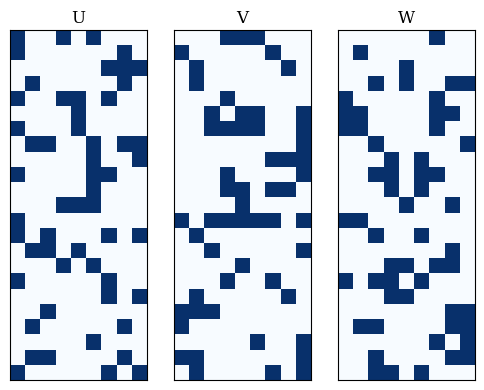

In [42]:
U, V, W = (int2bin(M, d)[0].cpu() for (M, d) in zip(UVW[:1].permute(1, 0, 2), dims))

fig, (ax_u, ax_v, ax_w) = plt.subplots(1, 3, figsize=(6,6))
ax_u.matshow(U, cmap='Blues')
ax_v.matshow(V, cmap='Blues')
ax_w.matshow(W, cmap='Blues')

ax_u.set_title("U")
ax_v.set_title("V")
ax_w.set_title("W")

for ax in (ax_u, ax_v, ax_w):
    ax.set_xticks([])
    ax.set_yticks([])